# PyGenetics
## Генетический алгоритм

In [1]:
import numpy as np
import random as rd
from math import *
import matplotlib.pyplot as plt

In [2]:
class Gen:
    """
    Класс Ген
    Описывает имя гена, отрезок [a;b] его значений, метод инициилизирования рандомного значения на этом отрезке,
    метод проверки этого значения, а также методы скрещивания и мутации генов.
    """
    def __init__(self, a, b, name):
        self.a = min(a, b)
        self.b = max(a, b)
        self.name = name
    
    def init_gen(self):
        return rd.uniform(self.a, self.b)
    
    def validate_value(self, value):
        if value < self.a:
            return self.a
        elif value > self.b:
            return self.b
        else:
            return value
    
    def crossingover(self, gen1, gen2, parametr):
        gen1, gen2 = min(gen1, gen2), max(gen1, gen2)
        g_left  = gen1 - (gen2 - gen1) * parametr
        g_right = gen2 + (gen2 - gen1) * parametr
        return self.validate_value(rd.uniform(g_left, g_right)) 
        
    def mutation(self, gen, parametr):
        g_left  = self.validate_value(gen - (self.b - self.a) * 0.5 * parametr)
        g_right = self.validate_value(gen + (self.b - self.a) * 0.5 * parametr)
        return rd.uniform(g_left, g_right)

In [3]:
class Chromosome:
    """
    Класс Хромосома (индивид) - совокупность генов
    """

    def __init__(self, genes):
        self.dict_genes = {gen.name: gen for gen in genes}
        
    def __getitem__(self, key):
        return self.dict_genes[key]

    def init_chromo(self):
        return {gen: self[gen].init_gen() for gen in self.dict_genes}

    def crossingover(self, chromo_parent_1, chromo_parent_2, parametr): 
        return {gen: self[gen].crossingover(chromo_parent_1[gen], chromo_parent_2[gen], parametr)
                for gen in self.dict_genes}

    def mutation(self, chromo_parent, genes, parametr):
        mutant = dict(chromo_parent)
        mutant.pop('fitness')
        for gen in genes:
            mutant[gen] = self[gen].mutation(mutant[gen], parametr)
        return mutant

In [4]:
class Population:
    
    """
    Класс Популяция
    По умолчанию ф-ция run ищет maximum оптимизации. При необходимости поиска minimum значение целевой функции
    следует возвращать с обратным знаком
    """
    
    def __init__(self, chromo, target, n_chromo=100, n_child=50, n_elite=1, population=None,
                 age=0, age_end=100, cross=0.1, mut=0.4, p_mut_chromo=0.1, p_mut_gen=0.3,
                 weis_loosers=0.5, weis_mutant=1, weis_children=1):
        self.chromo = chromo
        self.foo = target
        self.population = population
        self.age = age
        self.age_end = age_end
        self.n_chromo = n_chromo
        self.n_child = n_child
        self.n_elite = n_elite
        self.p_mut_chromo = p_mut_chromo
        self.p_mut_gen = p_mut_gen
        self.cross = cross
        self.mut = mut
        self.weis_mutant = weis_mutant
        self.weis_children = weis_children
        self.weis_loosers = weis_loosers
        
    def run(self):
        population = Population(self.chromo, self.foo, self.n_chromo, self.n_child, self.n_elite, self.population,
                               self.age, self.age_end, self.cross, self.mut, self.p_mut_chromo, self.p_mut_gen,
                               self.weis_loosers, self.weis_mutant, self.weis_children)
        population.init_population()
        dict_result = {'population': [], 'best': [], 'age': []}
        for _ in range(self.age_end):
            dict_result['population'].append(population.population)
            population.find_fitness_value()
            dict_result['best'].append(population.get_best_chromo())
            children = population.get_children()
            mutants  = population.get_mutants()
            population = population.get_next_population(children, mutants)
            dict_result['age'].append(population.age)
        dict_result['fitness'] = [chromo['fitness'] for chromo in dict_result['best']]
        return dict_result
        
    def init_population(self):
        self.population = [self.chromo.init_chromo() for _ in range(self.n_chromo)]
        
    def find_fitness_value(self):
        for chromo in self.population:
            chromo['fitness'] = self.foo(chromo)
    
    def get_children(self):
        def get_winner():
            chromo1, chromo2 = rd.choices(population=self.population, k=2)
            return chromo1 if chromo1['fitness'] > chromo2['fitness'] else chromo2
        parents = [get_winner() for _ in range(self.n_chromo)]
        return [self.chromo.crossingover(p1, p2, self.cross)
                for p1, p2 in zip(parents[:self.n_child], parents[self.n_child:])]
    
    def get_mutants(self):
        mutants = []
        for chromo in self.population:
            if rd.random() < self.p_mut_chromo:
                mutate_genes = [gen for gen in chromo if gen != 'fitness' and rd.random() < self.p_mut_gen]
                mutant = self.chromo.mutation(chromo, mutate_genes, self.mut)
                mutants.append(mutant)
        return mutants
    
    def get_next_population(self, children, mutants):
        population_sort = sorted(self.population, key=lambda chromo: chromo['fitness'], reverse=True)
        loosers = population_sort[self.n_elite:]
        weights_loosers  = [self.weis_loosers]  * len(loosers)
        weights_children = [self.weis_children] * len(children)
        weights_mutant   = [self.weis_mutant]   * len(mutants)
        next_population = rd.choices(population = loosers + children + mutants,
                                     weights = weights_loosers + weights_children + weights_mutant,
                                     k = self.n_chromo - self.n_elite)
        next_population += population_sort[:self.n_elite]
        return Population(chromo=self.chromo, target=self.foo,
                          population=next_population, age=self.age+1)
    
    def get_best_chromo(self):
        population = [chromo for chromo in self.population if 'fitness' in chromo]
        return max(population, key=lambda chromo: chromo['fitness'])

#### Как пользоваться? Инструкция по выживанию

In [25]:
def some_func(chromo):
    summ = 0.0
    for value in chromo.values():
        summ += abs(value)
    return -summ

In [26]:
# Инициилизируем гены: координаты и соответсвующие отрезки значений
alpha = 5
betta = 5
gen1 = Gen(-alpha, alpha, 'x1')
gen2 = Gen(-betta, betta, 'x2')
genes = [gen1, gen2]

In [27]:
# Экземпляр хромосомы (индивида популяции) - совокупность (список list) генов
chromo = Chromosome(genes)

In [28]:
# Создаем популяцию
pop = Population(chromo, target=some_func, age_end=50)

In [29]:
# Запускаем эволюцию
%time res = pop.run()

Wall time: 147 ms


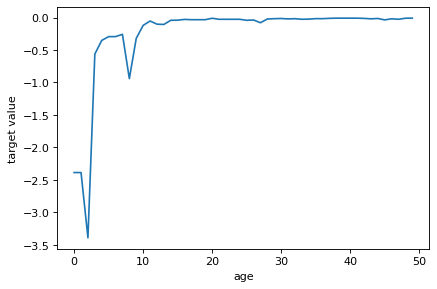

In [30]:
# Визуализируем
plt.figure(dpi=80)
plt.plot(res['fitness'])
plt.ylabel('target value')
plt.xlabel('age')
plt.show()

In [31]:
# Оптимум
res['fitness'][-1]

-0.010091622737223818

In [32]:
arr_x1 = [[res['population'][j][i]['x1'] for i in range(len(res['population'][j]))
  if 'fitness' in res['population'][j][i]] for j in range(len(res['population']))]
arr_x2 = [[res['population'][j][i]['x2'] for i in range(len(res['population'][j]))
  if 'fitness' in res['population'][j][i]] for j in range(len(res['population']))]
arr_f = [[res['population'][j][i]['fitness'] for i in range(len(res['population'][j]))
  if 'fitness' in res['population'][j][i]] for j in range(len(res['population']))]

In [33]:
from IPython.display import display
from ipywidgets import interact
#-------------------------------------------------------------------
#          Визуализация популяций в каждом поколении age
#-------------------------------------------------------------------
@interact(interactive = ['chromo(age) in (x1; x2)', 'chromo(age) in (best fitness; age)'])
def foo_lang(interactive):
    #----------------------------------------
    if interactive == 'chromo(age) in (x1; x2)':
        @interact(age = (1, pop.age_end, 1), pixel = (1, 300, 1))
        def plot_foo(age = 1, pixel=200):
            x1edges, x2edges = np.linspace(-alpha, alpha, pixel), np.linspace(-betta, betta, pixel)
            extent = [x1edges[0], x1edges[-1], x2edges[-1], x2edges[0]]
            heatmap = np.zeros((pixel, pixel))
            for i, x in enumerate(x1edges):
                for j, y in enumerate(x2edges):
                    heatmap[i, j] = some_func({'x': x, 'y': y})
            fig, ax = plt.subplots(dpi=100)
            plt.scatter(arr_x1[age-1], arr_x2[age-1], s=1, c='red')
            cax = ax.imshow(heatmap, extent=extent)
            fig.colorbar(cax)
            plt.xlabel('x$_{1}$', fontsize=14)
            plt.ylabel('x$_{2}$', fontsize=14)
            plt.title('$chromo(age)$', fontsize=14)
            plt.show()
    #----------------------------------------------------
    if interactive == 'chromo(age) in (best fitness; age)':
        @interact(age = (1, count_age, 1))
        def plot_foo(age = 0):
            plt.plot(res['fitness'][:age])
            plt.xlim(0, pop.age_end)
            plt.xlabel('age', fontsize=14)
            plt.ylabel('best fitness', fontsize=14)
            plt.title('$chromo(age)$', fontsize=14)
            plt.show()

interactive(children=(Dropdown(description='interactive', options=('chromo(age) in (x1; x2)', 'chromo(age) in …

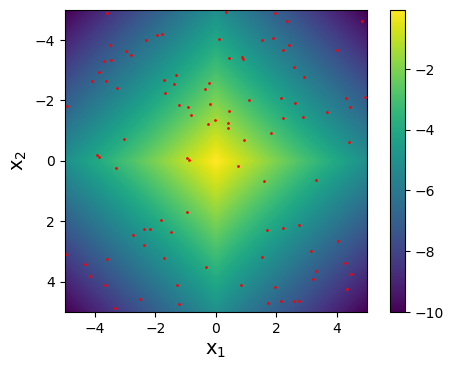

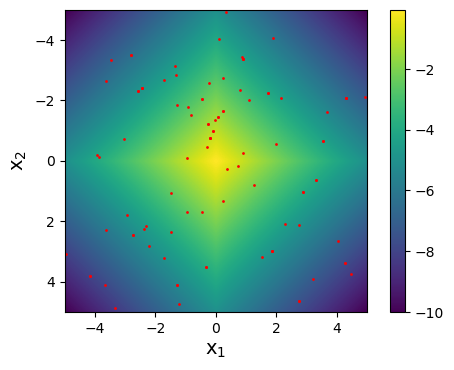

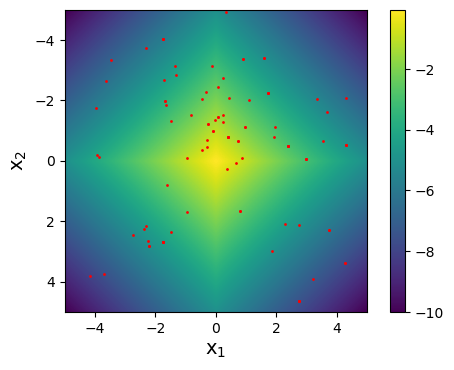

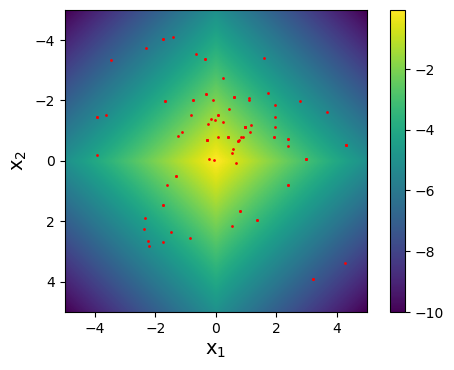

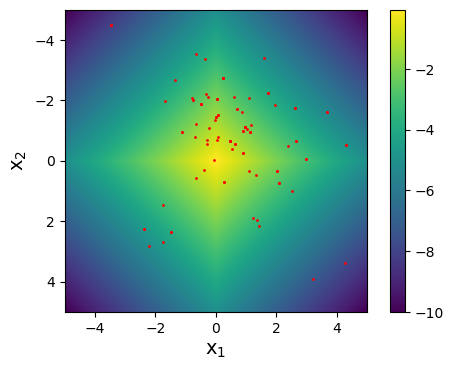

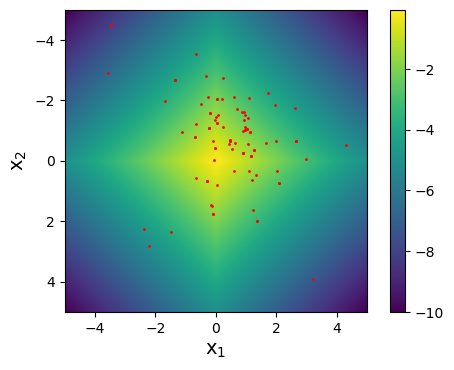

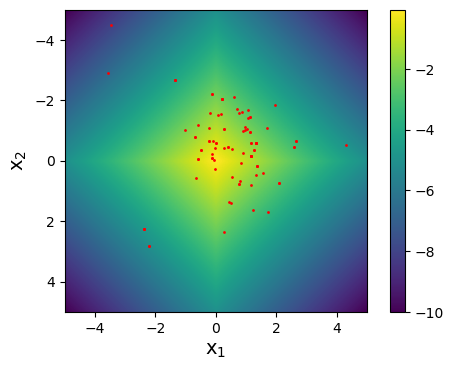

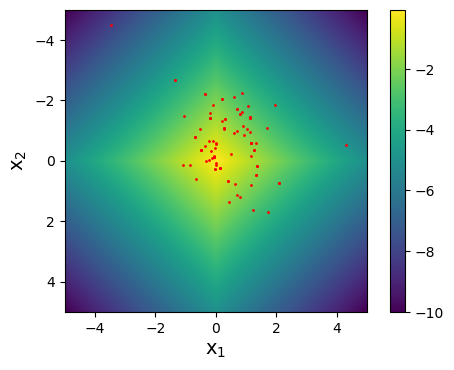

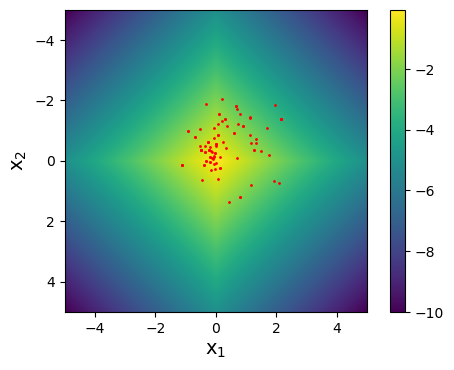

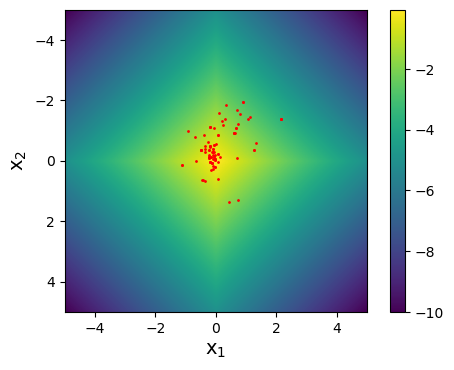

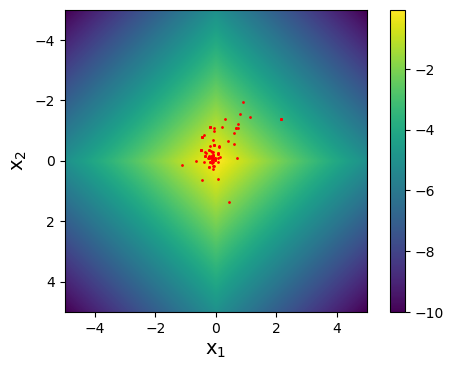

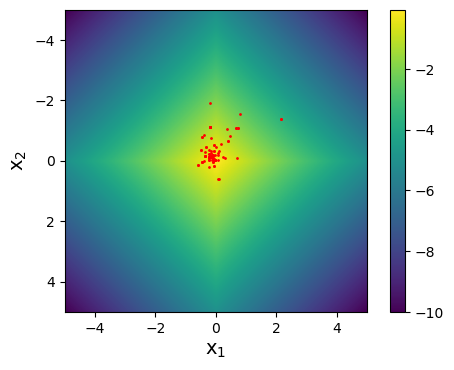

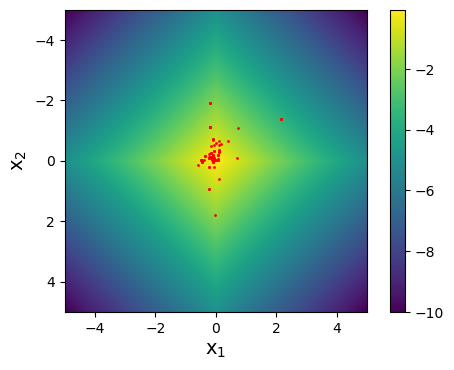

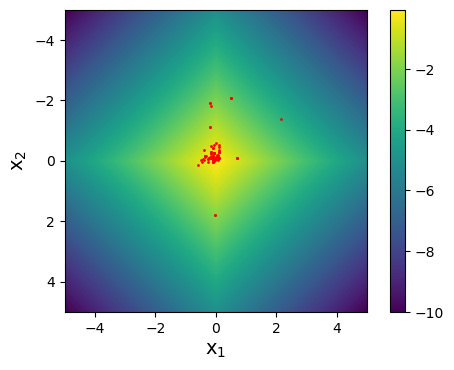

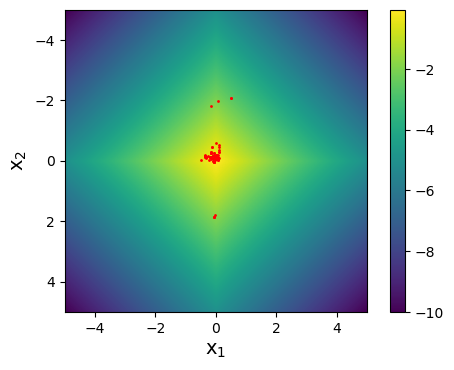

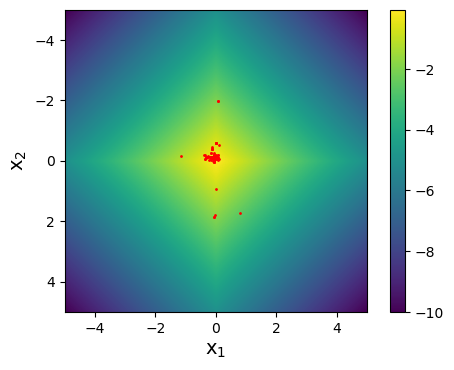

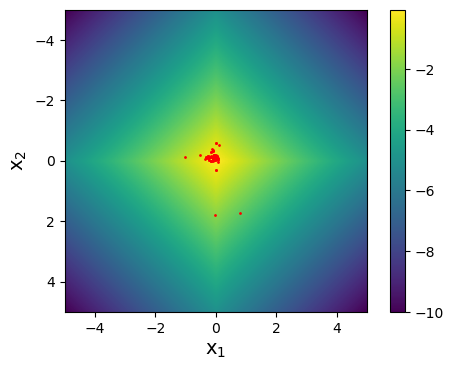

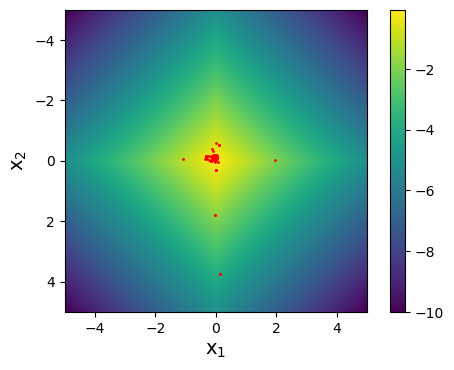

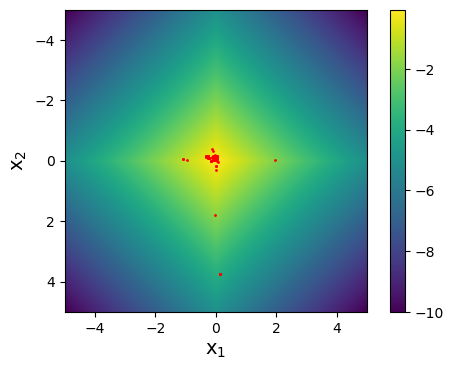

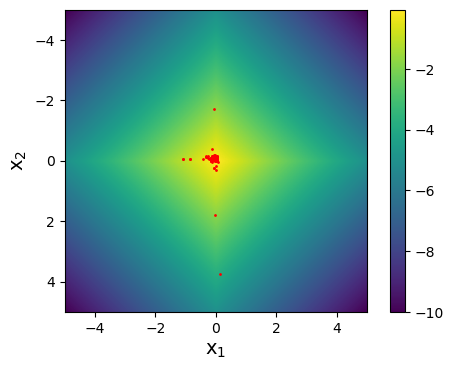

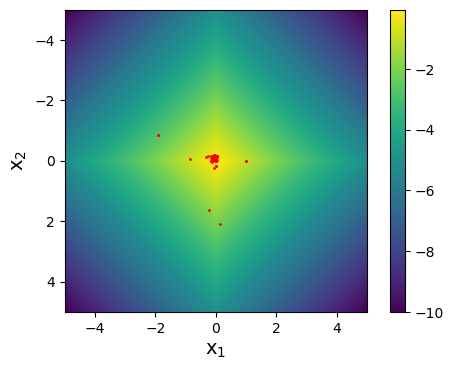

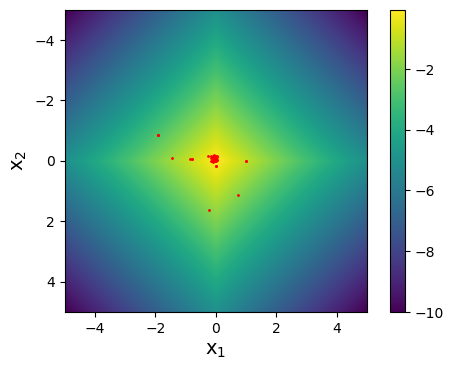

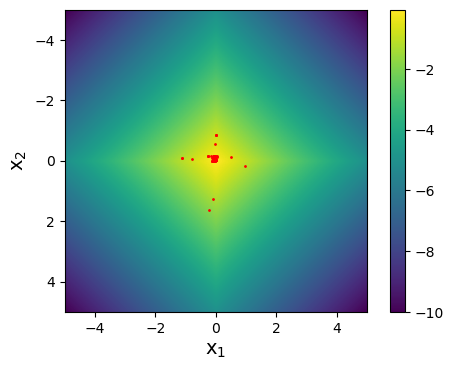

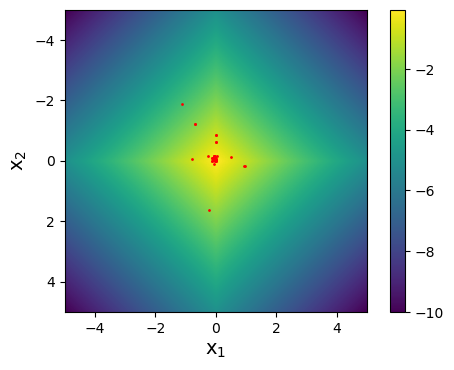

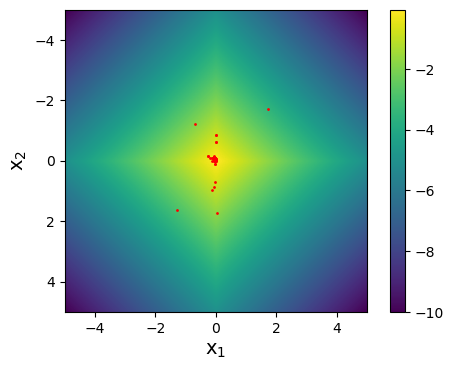

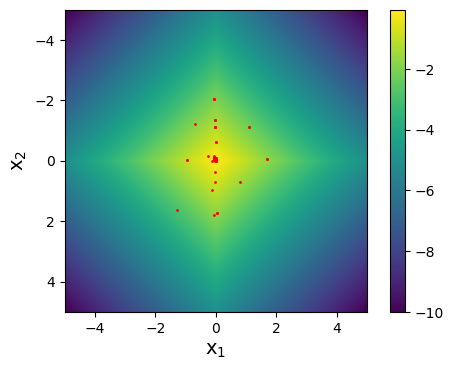

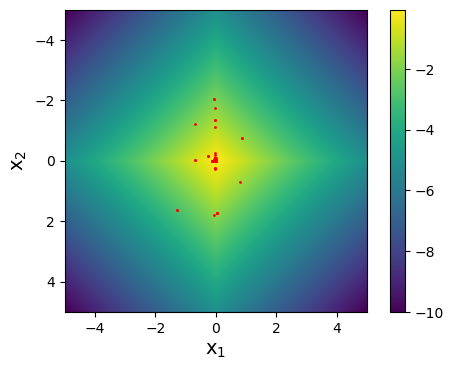

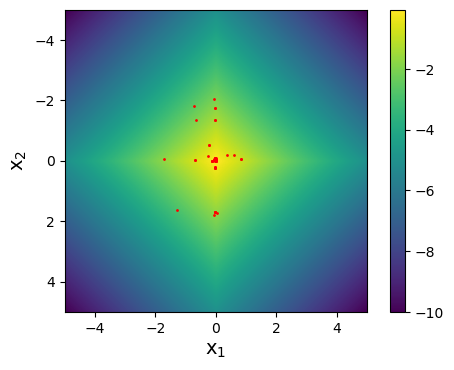

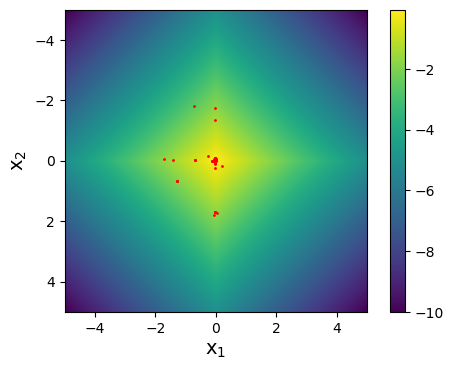

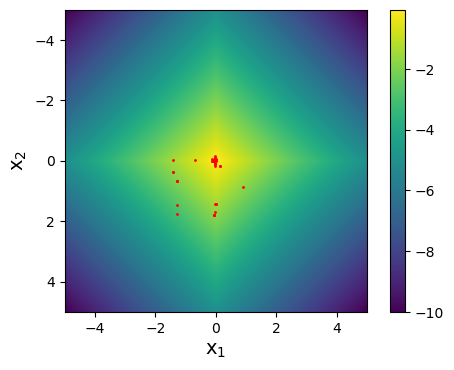

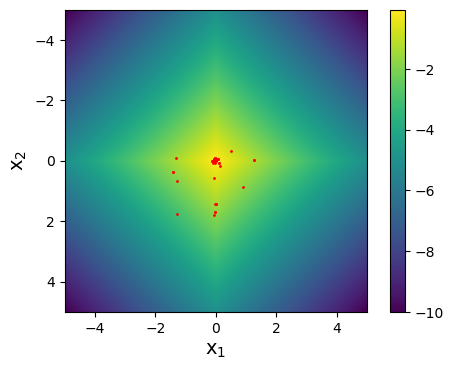

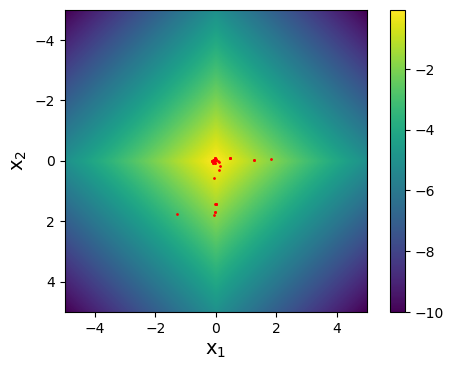

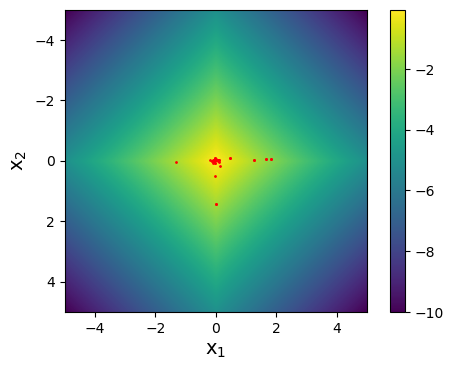

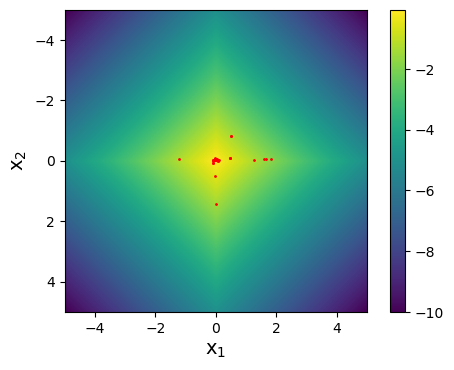

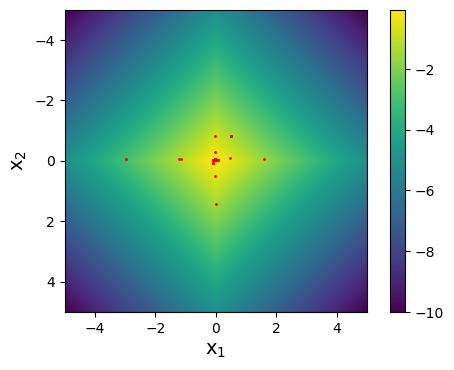

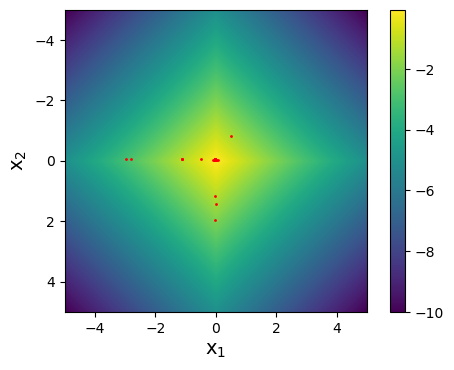

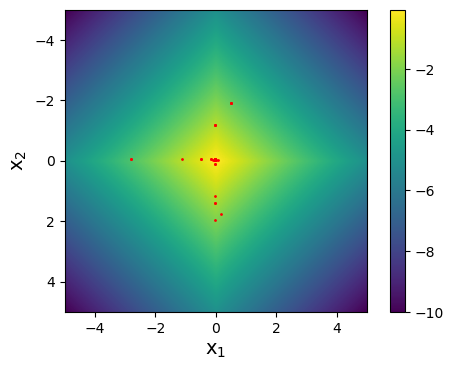

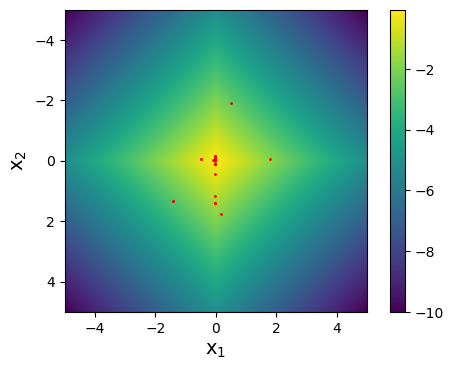

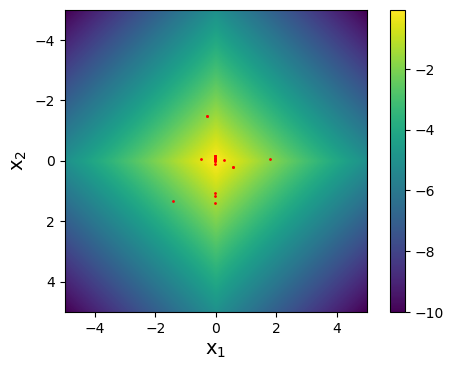

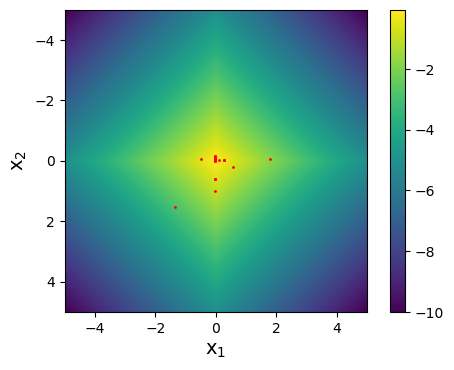

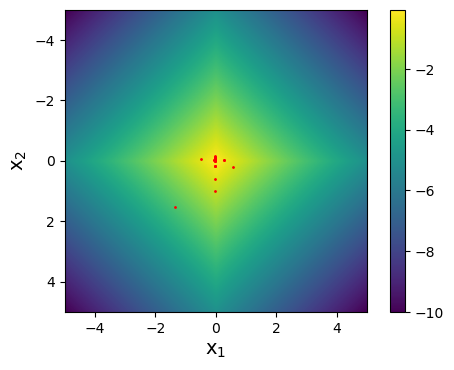

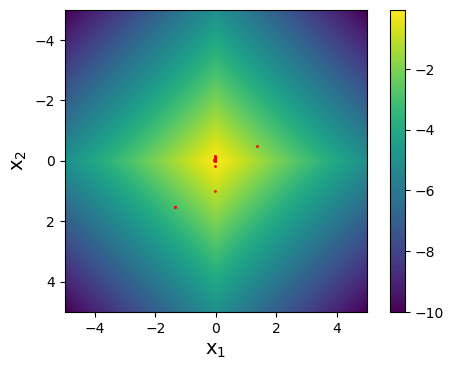

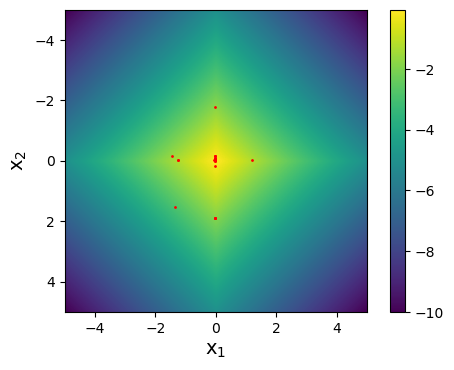

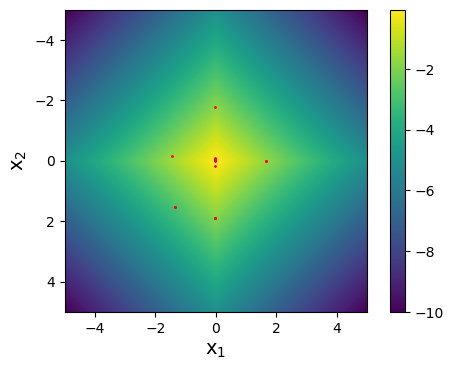

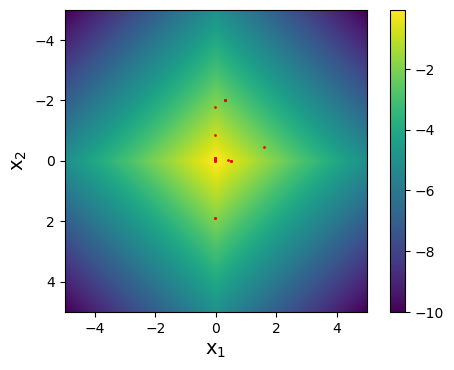

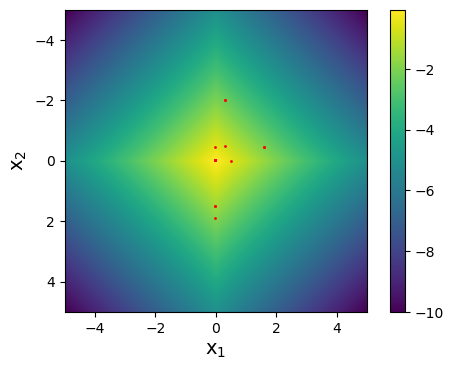

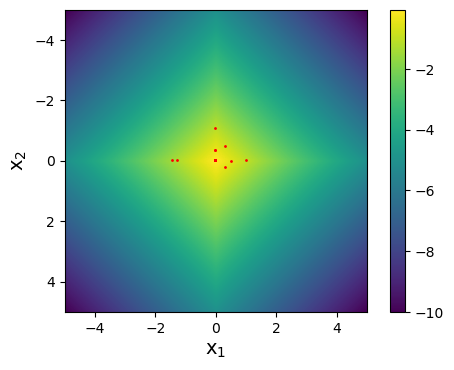

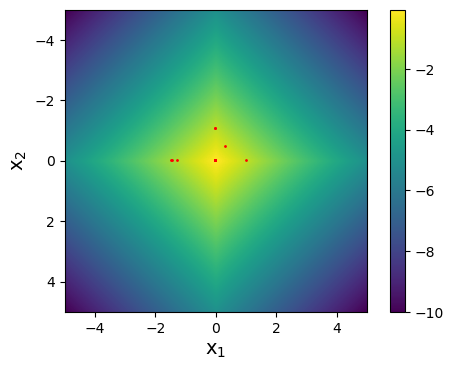

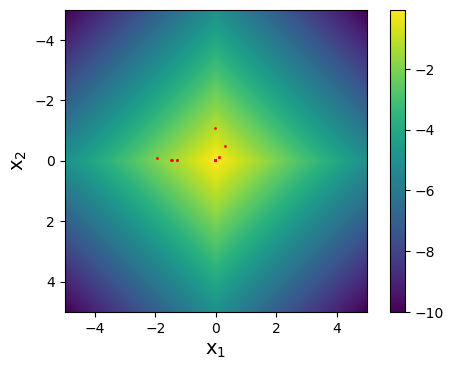

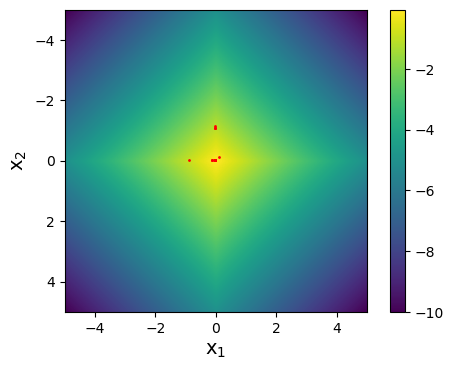

In [56]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
pixel = 200
for age in range(pop.age_end):
    fig, ax = plt.subplots(dpi=100)
    x1edges, x2edges = np.linspace(-alpha, alpha, pixel), np.linspace(-betta, betta, pixel)
    extent = [x1edges[0], x1edges[-1], x2edges[-1], x2edges[0]]
    heatmap = np.zeros((pixel, pixel))
    for i, x in enumerate(x1edges):
        for j, y in enumerate(x2edges):
            heatmap[i, j] = some_func({'x': x, 'y': y})
    cax = ax.imshow(heatmap, extent=extent)
    fig.colorbar(cax)
    plt.scatter(arr_x1[age], arr_x2[age], s=1, c='red')
    plt.xlabel('x$_{1}$', fontsize=14)
    plt.ylabel('x$_{2}$', fontsize=14)
#     plt.title(f'{age}', fontsize=14)
    filename = 'step'+str(age)+'.png'
    plt.savefig(filename, dpi=150)
    plt.show()